
 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom       15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom       22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.

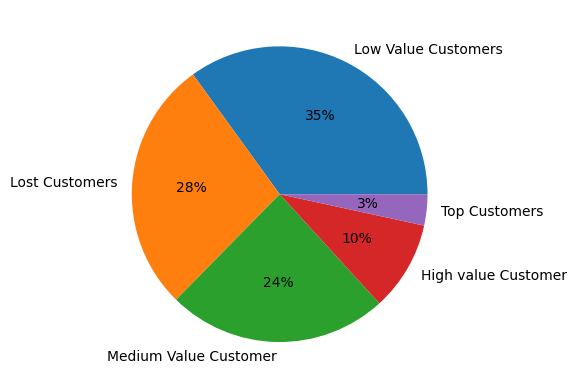

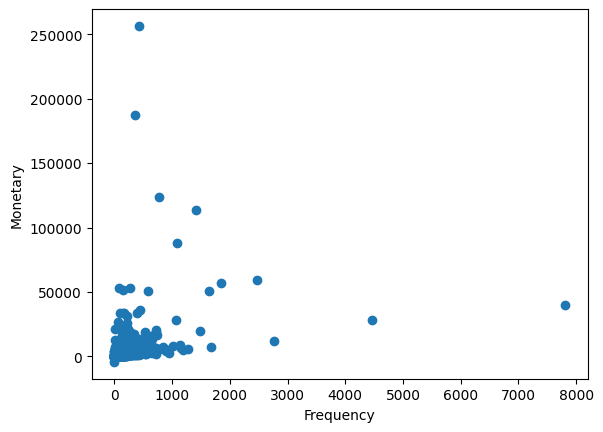

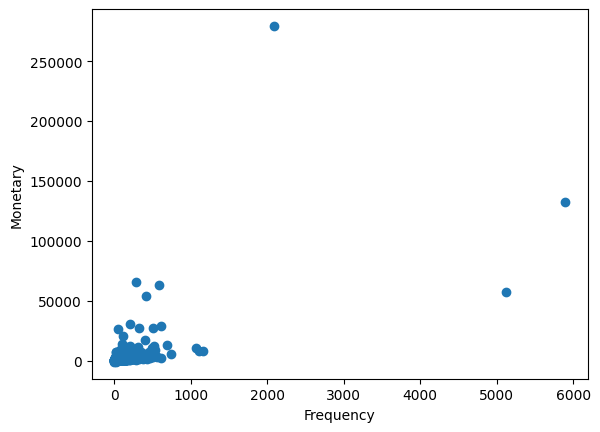

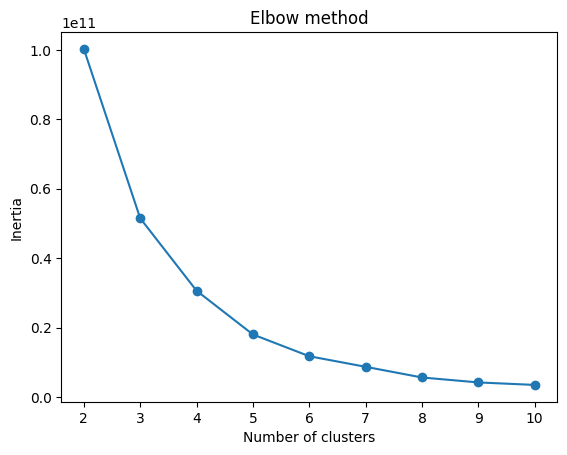


 kmeans.cluster_centers are :
[[0.01077743 0.02247649]
 [0.1036231  0.60620258]
 [0.78536679 0.14737662]]

 kmeans.intertia is :
2.2141122922121848


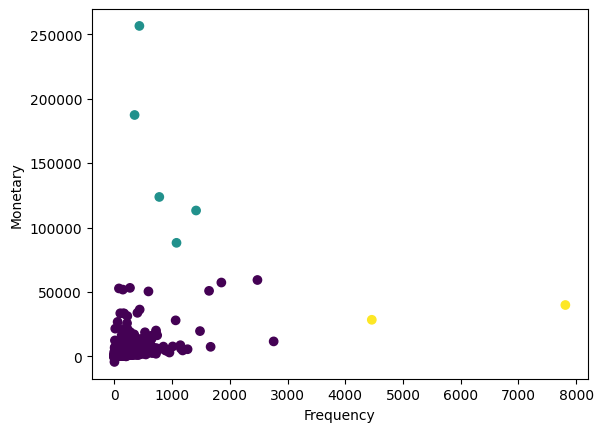


 Result: 9 out of 3497 samples are correctly labeled.

 Accuracy score due to K-Means Model: 0.00

 The Silhouette score for K-Means is : 
0.9695741493881367
Result: 3569 out of 4372 samples are correctly labeled.

 Accuracy score due to Gaussian Mixture Model: 0.82
DBSCAN algorithm did not generate enough clusters.


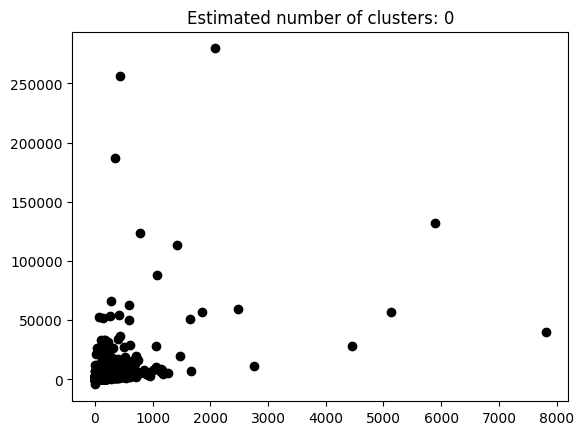

Agglomerative Score is :
0.950218922464673
Clusters of Birch [0 1 2]
Score of Birch =  0.950218922464673


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Read the excel file
with open('online retail.csv', 'r', encoding='latin1', errors='replace') as file:
    data = pd.read_csv(file)

# Data Cleaning

# Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

# Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

# Drop Duplicate Records
data.drop_duplicates(inplace=True)

# Displaying the Cleaned top five records of Dataframe
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print(data.head(5))

# RFM Analysis

# Calculating Recency
data_recency = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = pd.to_datetime(data_recency['LastInvoiceDate'].max(), dayfirst=True)  # Specify dayfirst=True
data_recency['LastInvoiceDate'] = pd.to_datetime(data_recency['LastInvoiceDate'], dayfirst=True)  # Specify dayfirst=True
data_recency['Recency'] = (recent_date - data_recency['LastInvoiceDate']).dt.days
print(data_recency.head(5))

# Calculating Frequency
frequency_data = data.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
print(frequency_data.head(5))

# Calculating Monetary Value
data['Total'] = data['UnitPrice'] * data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
print(monetary_data.head(5))

# Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns='LastInvoiceDate')
print(rfm_data.head(5))

# Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F_rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M_rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
print(rfm_data.head(5))

# Calculating RFM score
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
print(rfm_data[['CustomerID', 'RFM_Score']].head(5))

# Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] > 4.5, "Top Customers",
                                        (np.where(rfm_data['RFM_Score'] > 4,
                                                   "High value Customer",
                                                   (np.where(rfm_data['RFM_Score'] > 3,
                                                             "Medium Value Customer",
                                                             np.where(rfm_data['RFM_Score'] > 1.6,
                                                                      'Low Value Customers',
                                                                      'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
print(rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20))

# Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable
X = rfm_data[['Frequency', 'Monetary']]

# Split the data Train and Test
X_train, X_test = train_test_split(X, random_state=0, train_size=0.80)

# Plot of Train Data
plt.scatter(X_train['Frequency'], X_train['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Plot of Test Data
plt.scatter(X_test['Frequency'], X_test['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Elbow method to visualize the intertia
inertias = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_data[['Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_scaled)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train['Frequency'], X_train['Monetary'], c=kmeans.labels_)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Checking quality of classification by the K-Means model
labels = kmeans.labels_
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Evaluating performance of the clustering algorithm
# using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(metrics.silhouette_score(X_train_scaled, kmeans.labels_, metric='euclidean'))

# Gaussian Mixture Model
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=3)
gmm.fit(scaled_df)

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# DBSCAN Clustering Model (Distribution Based)

# Computing DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Check if there is more than one cluster
if n_clusters_ <= 1:
    print("DBSCAN algorithm did not generate enough clusters.")
else:
    # Proceed with silhouette score calculation
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


# Visualizing the clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Hierarchical Clustering
# Dendrogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method="ward"))

# Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")
cluster.fit_predict(X)
# Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Frequency'], X['Monetary'], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score
print('Agglomerative Score is :')
print(metrics.silhouette_score(X, cluster.labels_, metric='euclidean'))

# BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = np.unique(yhat_br)
print("Clusters of Birch", clusters_br)
labels_br = model_br.labels_
plt.scatter(X['Frequency'], X['Monetary'], c=yhat_br)
score_br = metrics.silhouette_score(X, labels_br)
print("Score of Birch = ", score_br)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Read the excel file
with open('online retail.csv', 'r', encoding='latin1', errors='replace') as file:
    data = pd.read_csv(file)

# Data Cleaning

# Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

# Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

# Drop Duplicate Records
data.drop_duplicates(inplace=True)

# Displaying the Cleaned top five records of Dataframe
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print(data.head(5))

# RFM Analysis

# Calculating Recency
data_recency = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = pd.to_datetime(data_recency['LastInvoiceDate'].max(), dayfirst=True)  # Specify dayfirst=True
data_recency['LastInvoiceDate'] = pd.to_datetime(data_recency['LastInvoiceDate'], dayfirst=True)  # Specify dayfirst=True
data_recency['Recency'] = (recent_date - data_recency['LastInvoiceDate']).dt.days
print(data_recency.head(5))

# Calculating Frequency
frequency_data = data.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
print(frequency_data.head(5))

# Calculating Monetary Value
data['Total'] = data['UnitPrice'] * data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
print(monetary_data.head(5))

# Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns='LastInvoiceDate')
print(rfm_data.head(5))

# Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F_rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M_rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
print(rfm_data.head(5))

# Calculating RFM score
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
print(rfm_data[['CustomerID', 'RFM_Score']].head(5))

# Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] > 4.5, "Top Customers",
                                        (np.where(rfm_data['RFM_Score'] > 4,
                                                   "High value Customer",
                                                   (np.where(rfm_data['RFM_Score'] > 3,
                                                             "Medium Value Customer",
                                                             np.where(rfm_data['RFM_Score'] > 1.6,
                                                                      'Low Value Customers',
                                                                      'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
print(rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20))

# Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable
X = rfm_data[['Frequency', 'Monetary']]

# Split the data Train and Test
X_train, X_test = train_test_split(X, random_state=0, train_size=0.80)

# Plot of Train Data
plt.scatter(X_train['Frequency'], X_train['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Plot of Test Data
plt.scatter(X_test['Frequency'], X_test['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Elbow method to visualize the intertia
inertias = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_data[['Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_scaled)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train['Frequency'], X_train['Monetary'], c=kmeans.labels_)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Checking quality of classification by the K-Means model
labels = kmeans.labels_
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Evaluating performance of the clustering algorithm
# using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(metrics.silhouette_score(X_train_scaled, kmeans.labels_, metric='euclidean'))

# Gaussian Mixture Model
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=3)
gmm.fit(scaled_df)

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# DBSCAN Clustering Model (Distribution Based)

# Computing DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Check if there is more than one cluster
if n_clusters_ <= 1:
    print("DBSCAN algorithm did not generate enough clusters.")
else:
    # Proceed with silhouette score calculation
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


# Visualizing the clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Hierarchical Clustering
# Dendrogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method="ward"))

# Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")
cluster.fit_predict(X)
# Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Frequency'], X['Monetary'], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score
print('Agglomerative Score is :')
print(metrics.silhouette_score(X, cluster.labels_, metric='euclidean'))

# BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = np.unique(yhat_br)
print("Clusters of Birch", clusters_br)
labels_br = model_br.labels_
plt.scatter(X['Frequency'], X['Monetary'], c=yhat_br)
score_br = metrics.silhouette_score(X, labels_br)
print("Score of Birch = ", score_br)



 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom       15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom       22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.

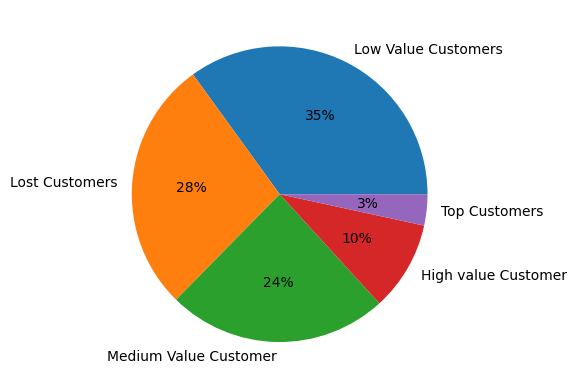

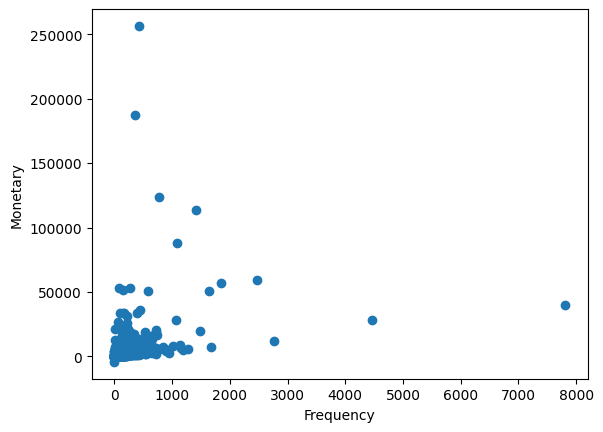

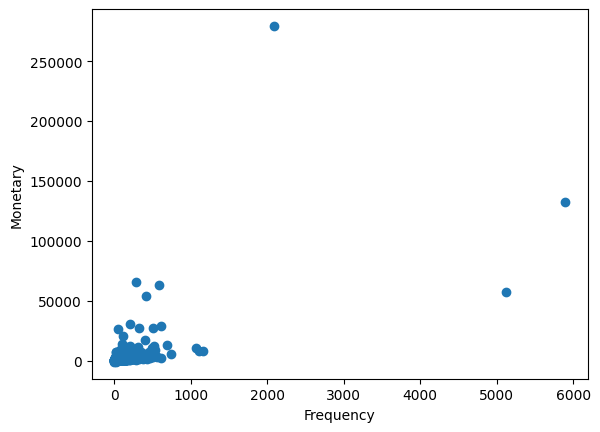

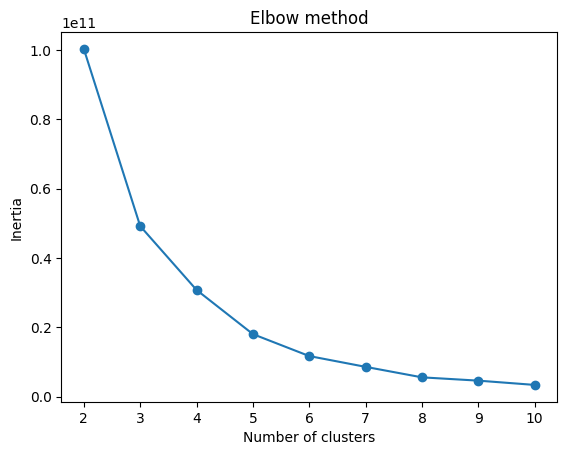


 kmeans.cluster_centers are :
[[0.01077743 0.02247649]
 [0.1036231  0.60620258]
 [0.78536679 0.14737662]]

 kmeans.intertia is :
2.2141122922121848


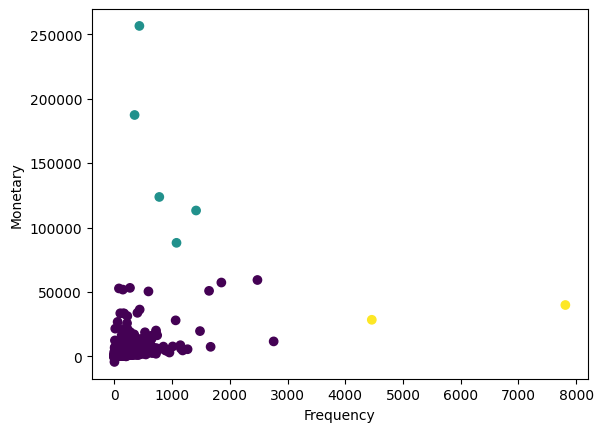


 Result: 9 out of 3497 samples are correctly labeled.

 Accuracy score due to K-Means Model: 0.00

 The Silhouette score for K-Means is : 
0.9695741493881367
Result: 3581 out of 4372 samples are correctly labeled.

 Accuracy score due to Gaussian Mixture Model: 0.82
DBSCAN algorithm did not generate enough clusters.


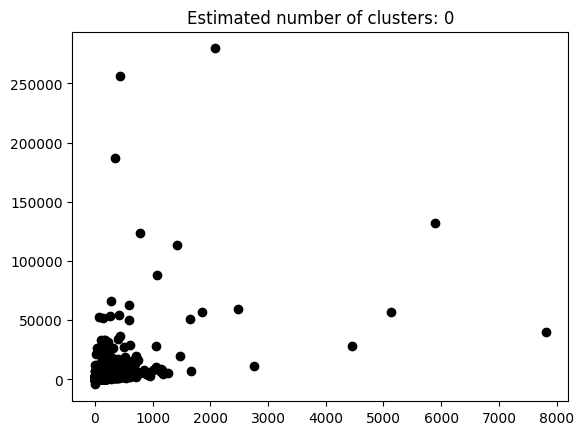

Agglomerative Score is :
0.950218922464673
Clusters of Birch [0 1 2]
Score of Birch =  0.950218922464673


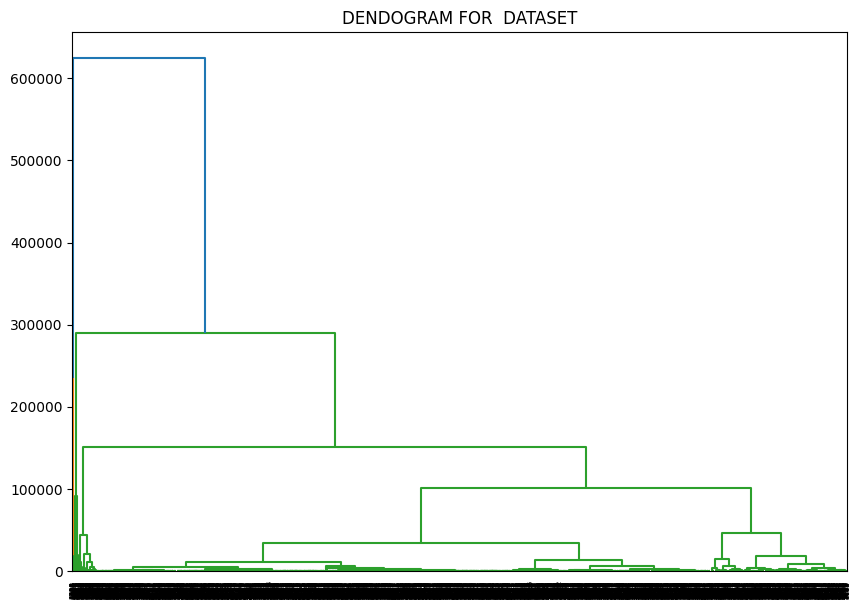

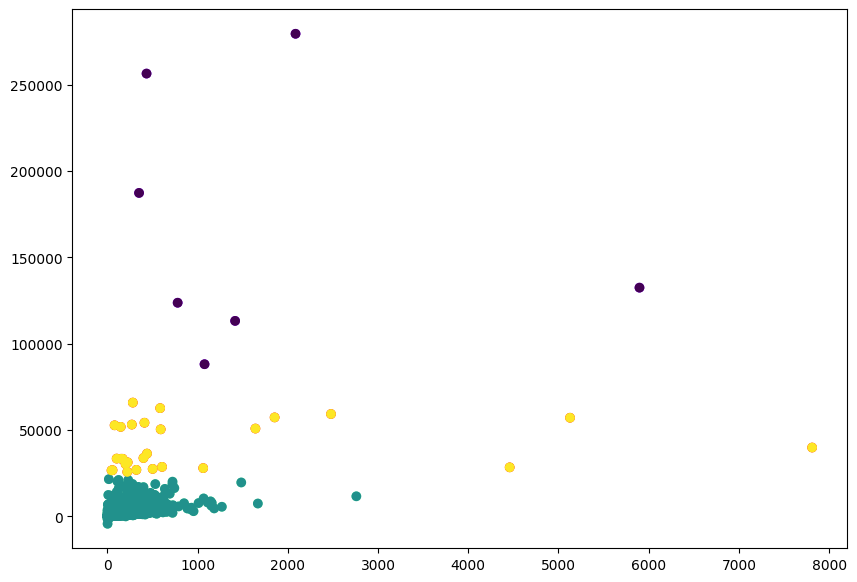

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Read the excel file
with open('online retail.csv', 'r', encoding='latin1', errors='replace') as file:
    data = pd.read_csv(file)

# Data Cleaning

# Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

# Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

# Drop Duplicate Records
data.drop_duplicates(inplace=True)

# Displaying the Cleaned top five records of Dataframe
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print(data.head(5))

# RFM Analysis

# Calculating Recency
data_recency = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = pd.to_datetime(data_recency['LastInvoiceDate'].max(), dayfirst=True)  # Specify dayfirst=True
data_recency['LastInvoiceDate'] = pd.to_datetime(data_recency['LastInvoiceDate'], dayfirst=True)  # Specify dayfirst=True
data_recency['Recency'] = (recent_date - data_recency['LastInvoiceDate']).dt.days
print(data_recency.head(5))

# Calculating Frequency
frequency_data = data.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
print(frequency_data.head(5))

# Calculating Monetary Value
data['Total'] = data['UnitPrice'] * data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
print(monetary_data.head(5))

# Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns='LastInvoiceDate')
print(rfm_data.head(5))

# Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F_rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M_rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
print(rfm_data.head(5))

# Calculating RFM score
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
print(rfm_data[['CustomerID', 'RFM_Score']].head(5))

# Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] > 4.5, "Top Customers",
                                        (np.where(rfm_data['RFM_Score'] > 4,
                                                   "High value Customer",
                                                   (np.where(rfm_data['RFM_Score'] > 3,
                                                             "Medium Value Customer",
                                                             np.where(rfm_data['RFM_Score'] > 1.6,
                                                                      'Low Value Customers',
                                                                      'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
print(rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20))

# Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable
X = rfm_data[['Frequency', 'Monetary']]

# Split the data Train and Test
X_train, X_test = train_test_split(X, random_state=0, train_size=0.80)

# Plot of Train Data
plt.scatter(X_train['Frequency'], X_train['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Plot of Test Data
plt.scatter(X_test['Frequency'], X_test['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Elbow method to visualize the intertia
inertias = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_data[['Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_scaled)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train['Frequency'], X_train['Monetary'], c=kmeans.labels_)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Checking quality of classification by the K-Means model
labels = kmeans.labels_
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Evaluating performance of the clustering algorithm
# using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(metrics.silhouette_score(X_train_scaled, kmeans.labels_, metric='euclidean'))

# Gaussian Mixture Model
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=3)
gmm.fit(scaled_df)

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# DBSCAN Clustering Model (Distribution Based)

# Computing DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Check if there is more than one cluster
if n_clusters_ <= 1:
    print("DBSCAN algorithm did not generate enough clusters.")
else:
    # Proceed with silhouette score calculation
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


# Visualizing the clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Hierarchical Clustering
# Dendrogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method="ward"))

# Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")
cluster.fit_predict(X)
# Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Frequency'], X['Monetary'], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score
print('Agglomerative Score is :')
print(metrics.silhouette_score(X, cluster.labels_, metric='euclidean'))

# BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = np.unique(yhat_br)
print("Clusters of Birch", clusters_br)
labels_br = model_br.labels_
plt.scatter(X['Frequency'], X['Monetary'], c=yhat_br)
score_br = metrics.silhouette_score(X, labels_br)
print("Score of Birch = ", score_br)



 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom       15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom       22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.

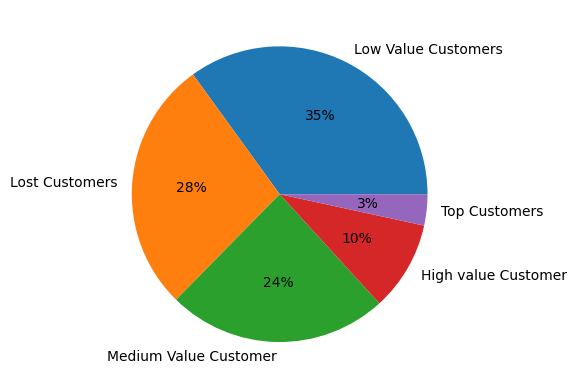

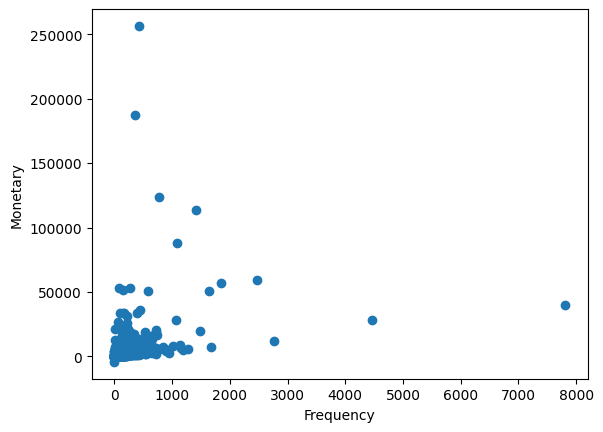

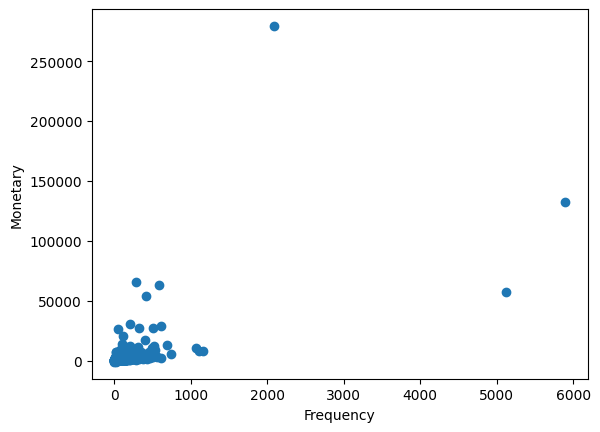

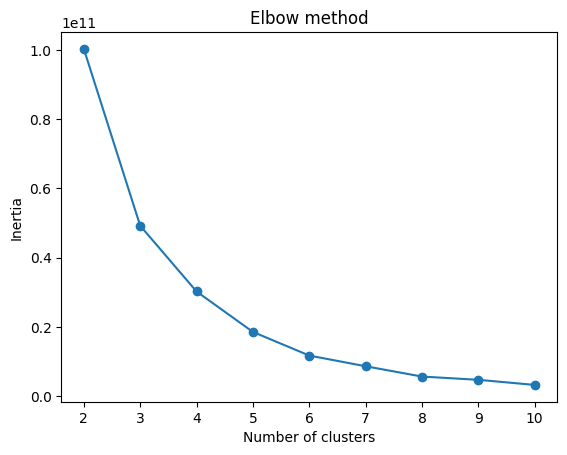


 kmeans.cluster_centers are :
[[0.01077743 0.02247649]
 [0.1036231  0.60620258]
 [0.78536679 0.14737662]]

 kmeans.intertia is :
2.2141122922121848


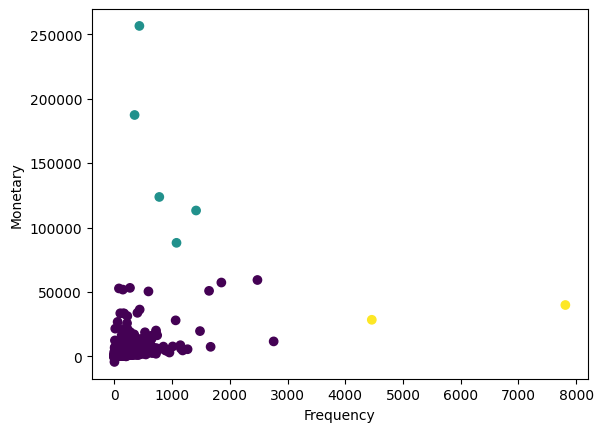


 Result: 9 out of 3497 samples are correctly labeled.

 Accuracy score due to K-Means Model: 0.00

 The Silhouette score for K-Means is : 
0.9695741493881367
Result: 5163 out of 4372 samples are correctly labeled.

 Accuracy score due to Gaussian Mixture Model: 1.18
DBSCAN algorithm did not generate enough clusters.


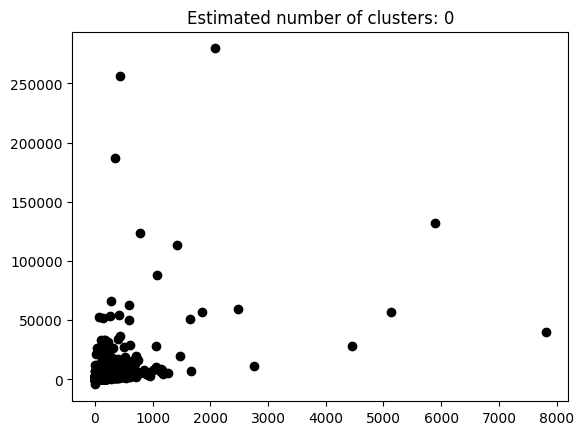

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

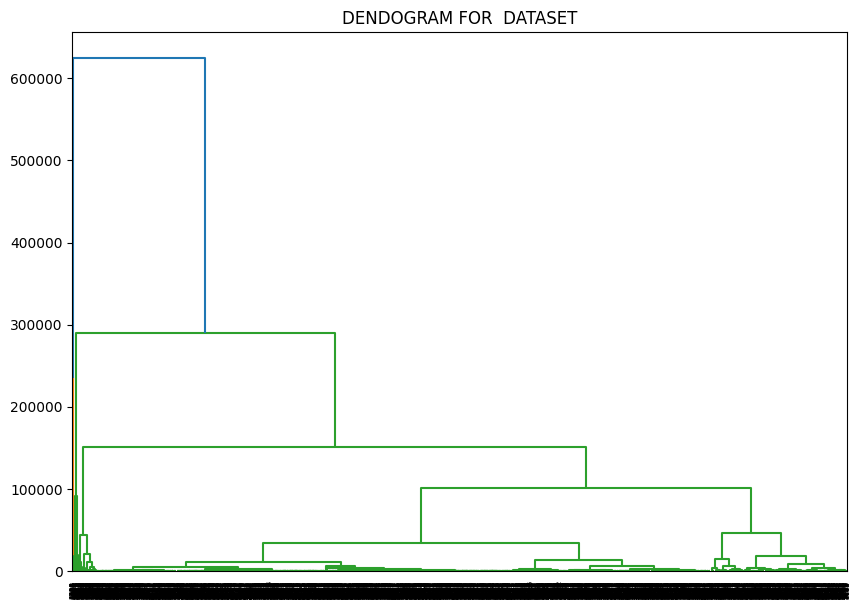

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Read the excel file
with open('online retail.csv', 'r', encoding='latin1', errors='replace') as file:
    data = pd.read_csv(file)

# Data Cleaning

# Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

# Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

# Drop Duplicate Records
data.drop_duplicates(inplace=True)

# Displaying the Cleaned top five records of Dataframe
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print(data.head(5))

# RFM Analysis

# Calculating Recency
data_recency = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = pd.to_datetime(data_recency['LastInvoiceDate'].max(), dayfirst=True)  # Specify dayfirst=True
data_recency['LastInvoiceDate'] = pd.to_datetime(data_recency['LastInvoiceDate'], dayfirst=True)  # Specify dayfirst=True
data_recency['Recency'] = (recent_date - data_recency['LastInvoiceDate']).dt.days
print(data_recency.head(5))

# Calculating Frequency
frequency_data = data.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
print(frequency_data.head(5))

# Calculating Monetary Value
data['Total'] = data['UnitPrice'] * data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
print(monetary_data.head(5))

# Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns='LastInvoiceDate')
print(rfm_data.head(5))

# Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F_rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M_rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
print(rfm_data.head(5))

# Calculating RFM score
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
print(rfm_data[['CustomerID', 'RFM_Score']].head(5))

# Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] > 4.5, "Top Customers",
                                        (np.where(rfm_data['RFM_Score'] > 4,
                                                   "High value Customer",
                                                   (np.where(rfm_data['RFM_Score'] > 3,
                                                             "Medium Value Customer",
                                                             np.where(rfm_data['RFM_Score'] > 1.6,
                                                                      'Low Value Customers',
                                                                      'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
print(rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20))

# Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable
X = rfm_data[['Frequency', 'Monetary']]

# Split the data Train and Test
X_train, X_test = train_test_split(X, random_state=0, train_size=0.80)

# Plot of Train Data
plt.scatter(X_train['Frequency'], X_train['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Plot of Test Data
plt.scatter(X_test['Frequency'], X_test['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Elbow method to visualize the intertia
inertias = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_data[['Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_scaled)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train['Frequency'], X_train['Monetary'], c=kmeans.labels_)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Checking quality of classification by the K-Means model
labels = kmeans.labels_
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Evaluating performance of the clustering algorithm
# using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(metrics.silhouette_score(X_train_scaled, kmeans.labels_, metric='euclidean'))

# Gaussian Mixture Model
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=3)
gmm.fit(scaled_df)

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# DBSCAN Clustering Model (Distribution Based)

# Computing DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Check if there is more than one cluster
if n_clusters_ <= 1:
    print("DBSCAN algorithm did not generate enough clusters.")
else:
    # Proceed with silhouette score calculation
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


# Visualizing the clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Hierarchical Clustering
# Dendrogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method="ward"))

# Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
cluster.fit_predict(X)
# Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Frequency'], X['Monetary'], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score
print('Agglomerative Score is :')
print(metrics.silhouette_score(X, cluster.labels_, metric='euclidean'))

# BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = np.unique(yhat_br)
print("Clusters of Birch", clusters_br)
labels_br = model_br.labels_
plt.scatter(X['Frequency'], X['Monetary'], c=yhat_br)
score_br = metrics.silhouette_score(X, labels_br)
print("Score of Birch = ", score_br)



 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom       15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom       22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.

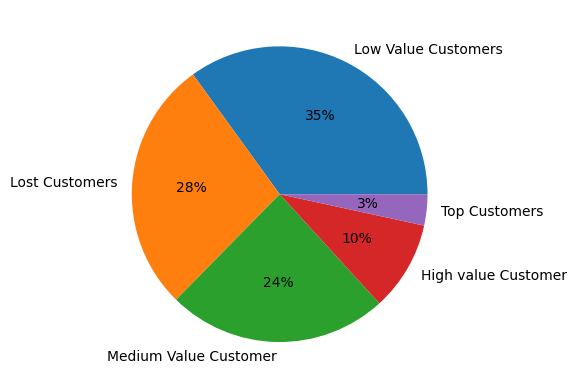

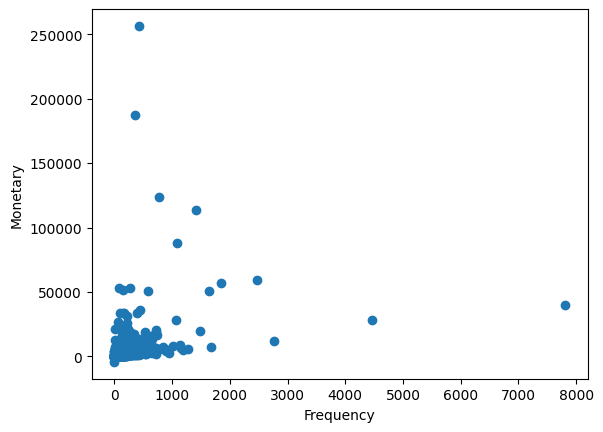

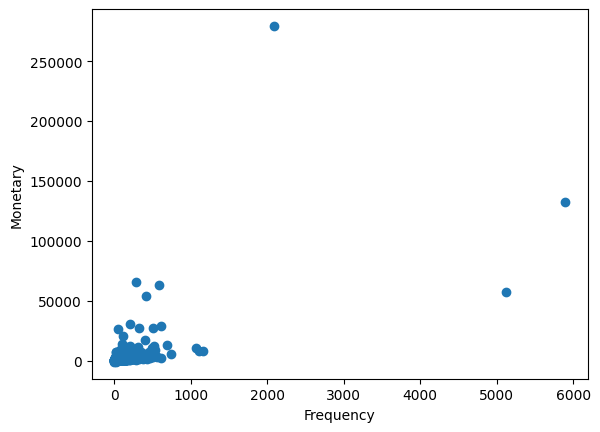

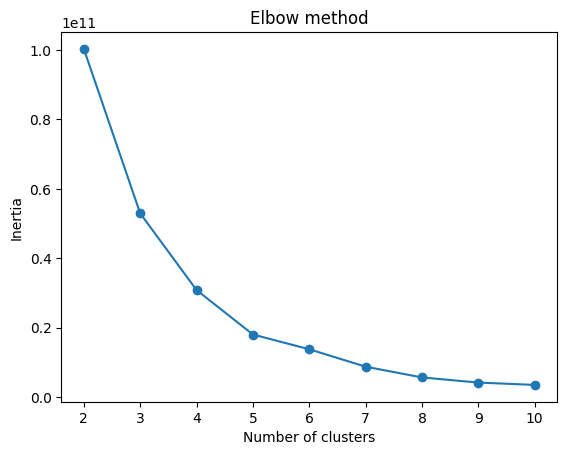


 kmeans.cluster_centers are :
[[0.01077743 0.02247649]
 [0.1036231  0.60620258]
 [0.78536679 0.14737662]]

 kmeans.intertia is :
2.2141122922121848


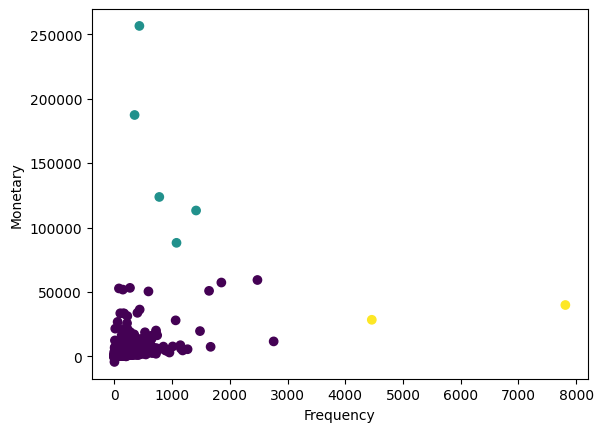


 Result: 9 out of 3497 samples are correctly labeled.

 Accuracy score due to K-Means Model: 0.00

 The Silhouette score for K-Means is : 
0.9695741493881367
Result: 3585 out of 4372 samples are correctly labeled.

 Accuracy score due to Gaussian Mixture Model: 0.82


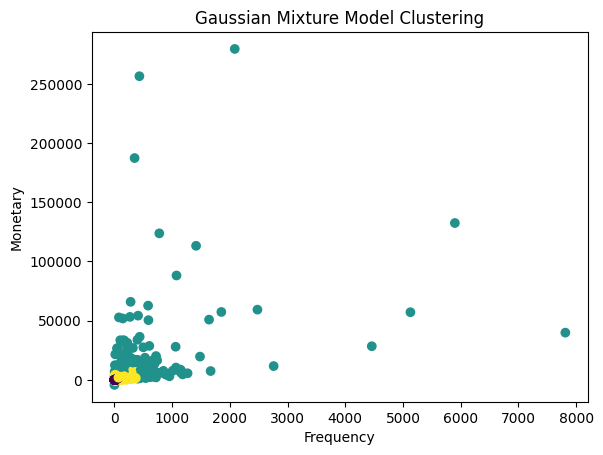

DBSCAN algorithm did not generate enough clusters.


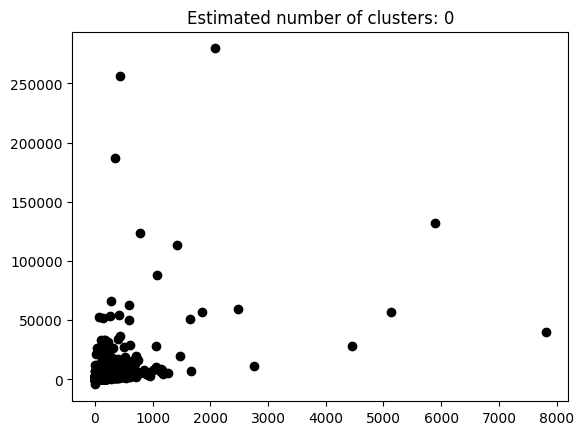

Agglomerative Score is :
0.950218922464673
Clusters of Birch [0 1 2]
Score of Birch =  0.950218922464673


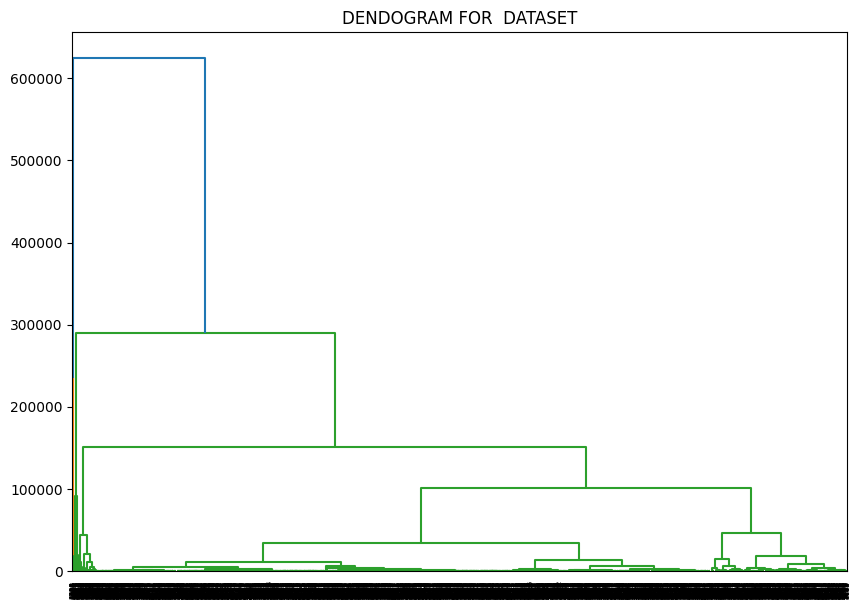

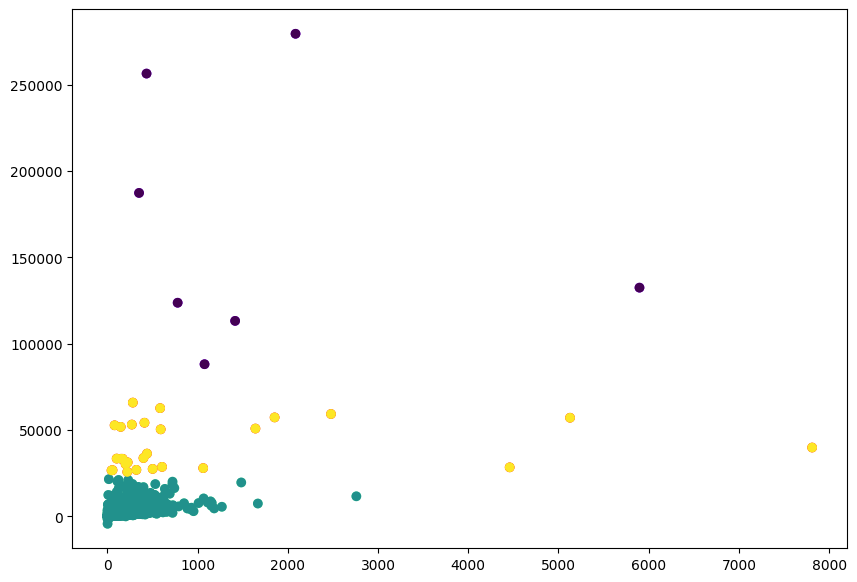

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Read the excel file
with open('online retail.csv', 'r', encoding='latin1', errors='replace') as file:
    data = pd.read_csv(file)

# Data Cleaning

# Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

# Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

# Drop Duplicate Records
data.drop_duplicates(inplace=True)

# Displaying the Cleaned top five records of Dataframe
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print(data.head(5))

# RFM Analysis

# Calculating Recency
data_recency = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = pd.to_datetime(data_recency['LastInvoiceDate'].max(), dayfirst=True)  # Specify dayfirst=True
data_recency['LastInvoiceDate'] = pd.to_datetime(data_recency['LastInvoiceDate'], dayfirst=True)  # Specify dayfirst=True
data_recency['Recency'] = (recent_date - data_recency['LastInvoiceDate']).dt.days
print(data_recency.head(5))

# Calculating Frequency
frequency_data = data.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
print(frequency_data.head(5))

# Calculating Monetary Value
data['Total'] = data['UnitPrice'] * data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
print(monetary_data.head(5))

# Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns='LastInvoiceDate')
print(rfm_data.head(5))

# Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F_rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M_rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
print(rfm_data.head(5))

# Calculating RFM score
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
print(rfm_data[['CustomerID', 'RFM_Score']].head(5))

# Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] > 4.5, "Top Customers",
                                        (np.where(rfm_data['RFM_Score'] > 4,
                                                   "High value Customer",
                                                   (np.where(rfm_data['RFM_Score'] > 3,
                                                             "Medium Value Customer",
                                                             np.where(rfm_data['RFM_Score'] > 1.6,
                                                                      'Low Value Customers',
                                                                      'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
print(rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20))

# Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable
X = rfm_data[['Frequency', 'Monetary']]

# Split the data Train and Test
X_train, X_test = train_test_split(X, random_state=0, train_size=0.80)

# Plot of Train Data
plt.scatter(X_train['Frequency'], X_train['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Plot of Test Data
plt.scatter(X_test['Frequency'], X_test['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Elbow method to visualize the intertia
inertias = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_data[['Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_scaled)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train['Frequency'], X_train['Monetary'], c=kmeans.labels_)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Checking quality of classification by the K-Means model
labels = kmeans.labels_
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Evaluating performance of the clustering algorithm
# using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(metrics.silhouette_score(X_train_scaled, kmeans.labels_, metric='euclidean'))

# Gaussian Mixture Model
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=3)
gmm.fit(scaled_df)

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Visualizing the clustering
plt.scatter(X['Frequency'], X['Monetary'], c=labels, cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Gaussian Mixture Model Clustering')
plt.show()

# DBSCAN Clustering Model (Distribution Based)

# Computing DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Check if there is more than one cluster
if n_clusters_ <= 1:
    print("DBSCAN algorithm did not generate enough clusters.")
else:
    # Proceed with silhouette score calculation
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


# Visualizing the clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Hierarchical Clustering
# Dendrogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method="ward"))

# Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")
cluster.fit_predict(X)
# Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Frequency'], X['Monetary'], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score
print('Agglomerative Score is :')
print(metrics.silhouette_score(X, cluster.labels_, metric='euclidean'))

# BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = np.unique(yhat_br)
print("Clusters of Birch", clusters_br)
labels_br = model_br.labels_
plt.scatter(X['Frequency'], X['Monetary'], c=yhat_br)
score_br = metrics.silhouette_score(X, labels_br)
print("Score of Birch = ", score_br)



 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom       15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom       22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.

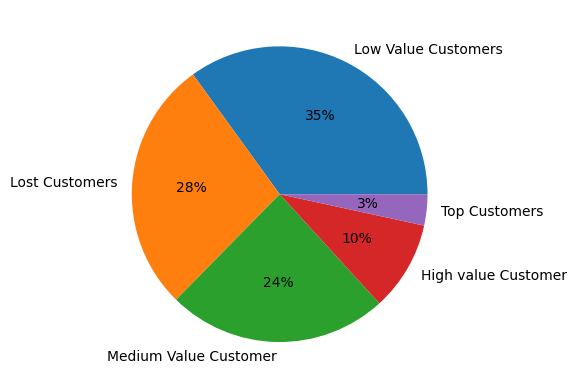

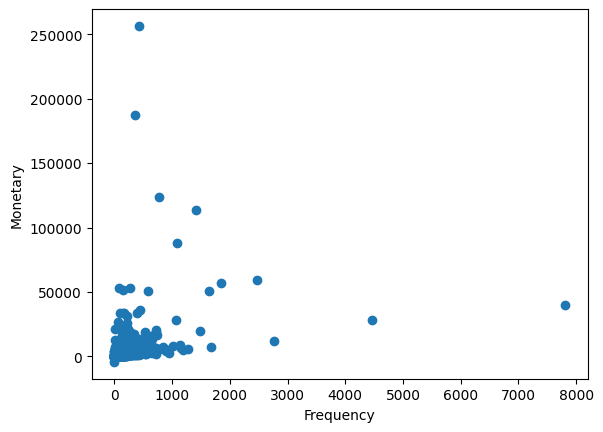

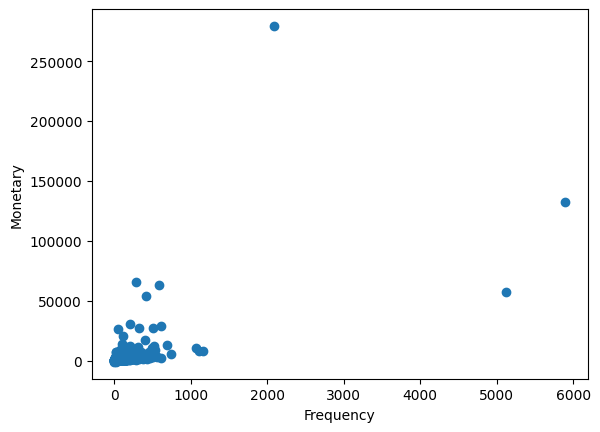

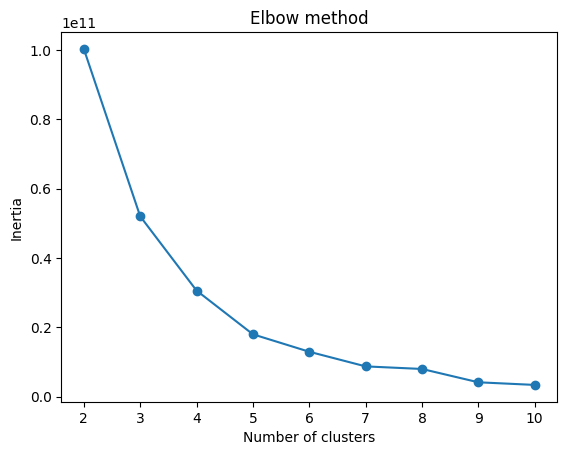


 kmeans.cluster_centers are :
[[0.01077743 0.02247649]
 [0.1036231  0.60620258]
 [0.78536679 0.14737662]]

 kmeans.intertia is :
2.2141122922121848


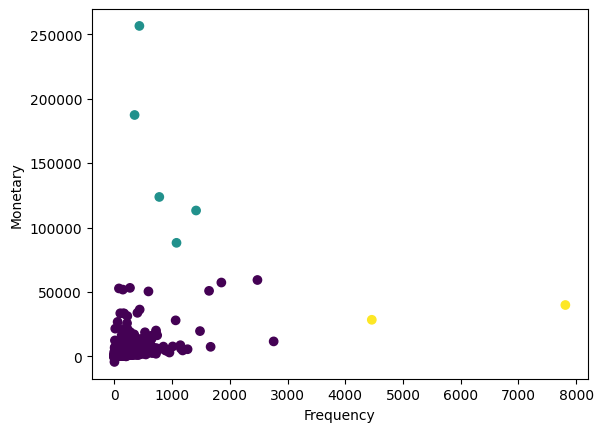


 Result: 9 out of 3497 samples are correctly labeled.

 Accuracy score due to K-Means Model: 0.00

 The Silhouette score for K-Means is : 
0.9695741493881367
Result: 3601 out of 4372 samples are correctly labeled.

 Accuracy score due to Gaussian Mixture Model: 0.82


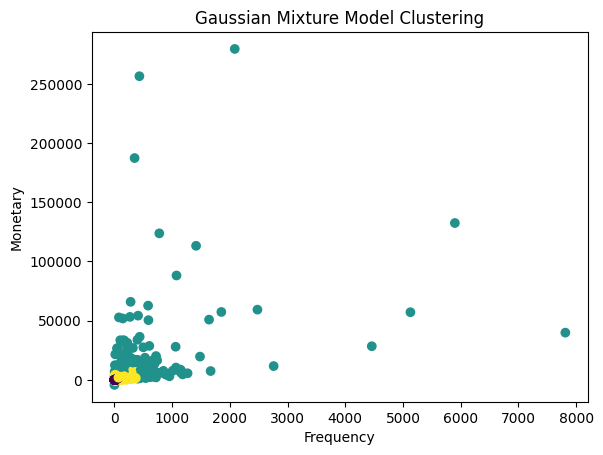

DBSCAN algorithm did not generate enough clusters.


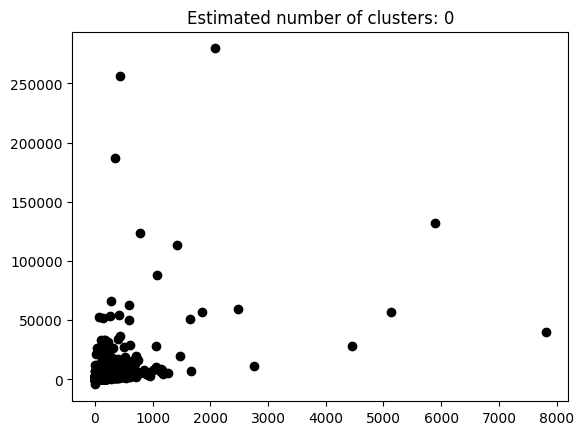

Agglomerative Score is :
0.950218922464673
Clusters of Birch [0 1 2]
Score of Birch =  0.950218922464673


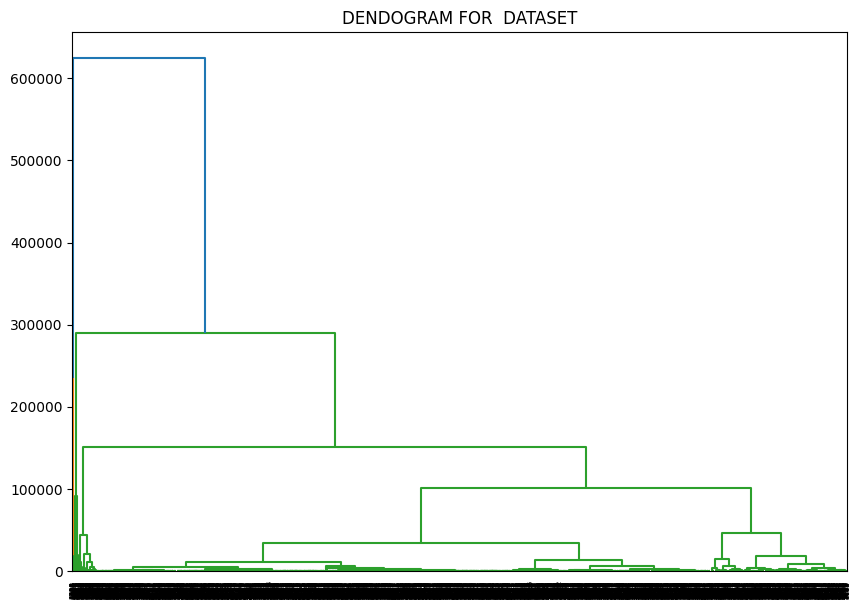

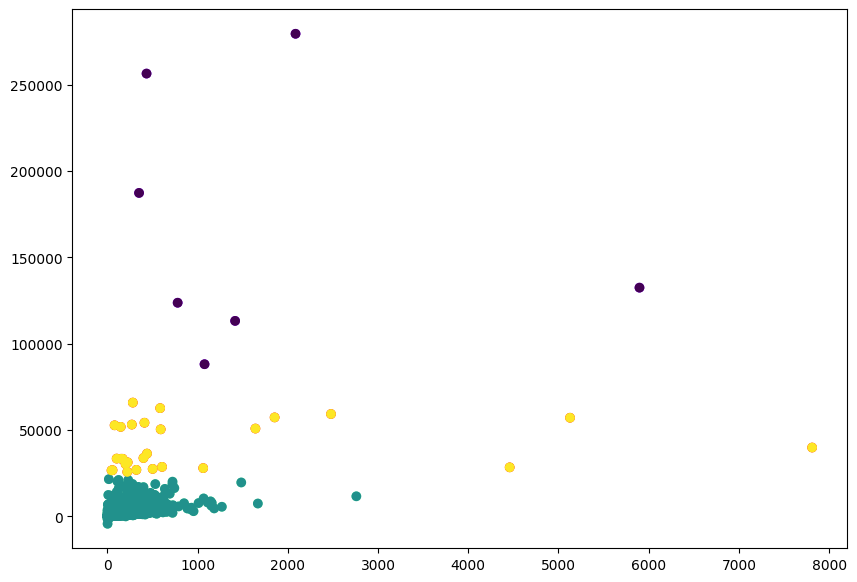

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Read the excel file
with open('online retail.csv', 'r', encoding='latin1', errors='replace') as file:
    data = pd.read_csv(file)

# Data Cleaning

# Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

# Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

# Drop Duplicate Records
data.drop_duplicates(inplace=True)

# Displaying the Cleaned top five records of Dataframe
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print(data.head(5))

# RFM Analysis

# Calculating Recency
data_recency = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = pd.to_datetime(data_recency['LastInvoiceDate'].max(), dayfirst=True)  # Specify dayfirst=True
data_recency['LastInvoiceDate'] = pd.to_datetime(data_recency['LastInvoiceDate'], dayfirst=True)  # Specify dayfirst=True
data_recency['Recency'] = (recent_date - data_recency['LastInvoiceDate']).dt.days
print(data_recency.head(5))

# Calculating Frequency
frequency_data = data.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
print(frequency_data.head(5))

# Calculating Monetary Value
data['Total'] = data['UnitPrice'] * data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
print(monetary_data.head(5))

# Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns='LastInvoiceDate')
print(rfm_data.head(5))

# Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F_rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M_rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
print(rfm_data.head(5))

# Calculating RFM score
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
print(rfm_data[['CustomerID', 'RFM_Score']].head(5))

# Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] > 4.5, "Top Customers",
                                        (np.where(rfm_data['RFM_Score'] > 4,
                                                   "High value Customer",
                                                   (np.where(rfm_data['RFM_Score'] > 3,
                                                             "Medium Value Customer",
                                                             np.where(rfm_data['RFM_Score'] > 1.6,
                                                                      'Low Value Customers',
                                                                      'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
print(rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20))

# Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable
X = rfm_data[['Frequency', 'Monetary']]

# Split the data Train and Test
X_train, X_test = train_test_split(X, random_state=0, train_size=0.80)

# Plot of Train Data
plt.scatter(X_train['Frequency'], X_train['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Plot of Test Data
plt.scatter(X_test['Frequency'], X_test['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Elbow method to visualize the intertia
inertias = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_data[['Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_scaled)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train['Frequency'], X_train['Monetary'], c=kmeans.labels_)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Checking quality of classification by the K-Means model
labels = kmeans.labels_
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Evaluating performance of the clustering algorithm
# using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(metrics.silhouette_score(X_train_scaled, kmeans.labels_, metric='euclidean'))

# Gaussian Mixture Model
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=3)
gmm.fit(scaled_df)

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Visualizing the clustering
plt.scatter(X['Frequency'], X['Monetary'], c=labels, cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Gaussian Mixture Model Clustering')
plt.show()

# DBSCAN Clustering Model (Distribution Based)

# Computing DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Check if there is more than one cluster
if n_clusters_ <= 1:
    print("DBSCAN algorithm did not generate enough clusters.")
else:
    # Proceed with silhouette score calculation
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    silhouette_db = metrics.silhouette_score(X, labels, metric='euclidean')
    print("Silhouette Coefficient: %0.3f" % silhouette_db)


# Visualizing the clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Hierarchical Clustering
# Dendrogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method="ward"))

# Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")
cluster.fit_predict(X)
# Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Frequency'], X['Monetary'], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score
print('Agglomerative Score is :')
silhouette_agg = metrics.silhouette_score(X, cluster.labels_, metric='euclidean')
print(silhouette_agg)

# BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = np.unique(yhat_br)
print("Clusters of Birch", clusters_br)
labels_br = model_br.labels_
plt.scatter(X['Frequency'], X['Monetary'], c=yhat_br)
score_br = metrics.silhouette_score(X, labels_br)
print("Score of Birch = ", score_br)




 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom       15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom       22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.

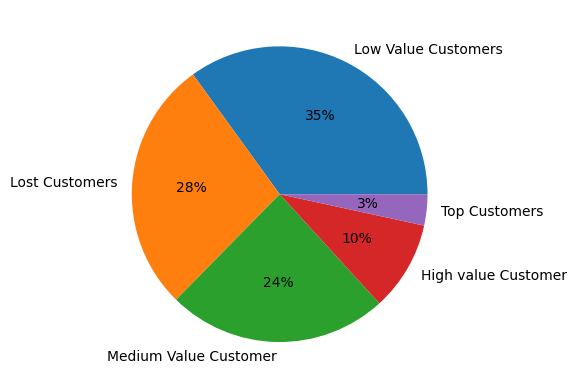

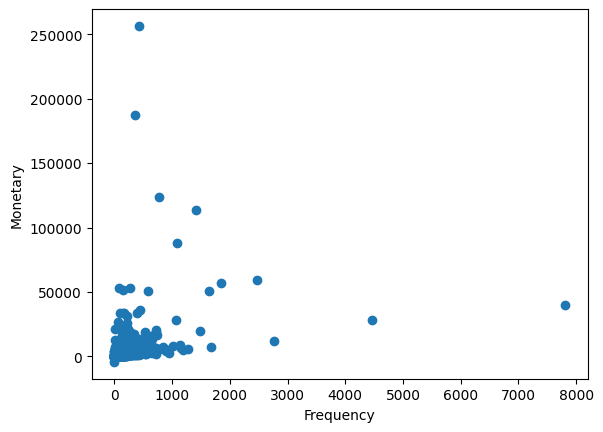

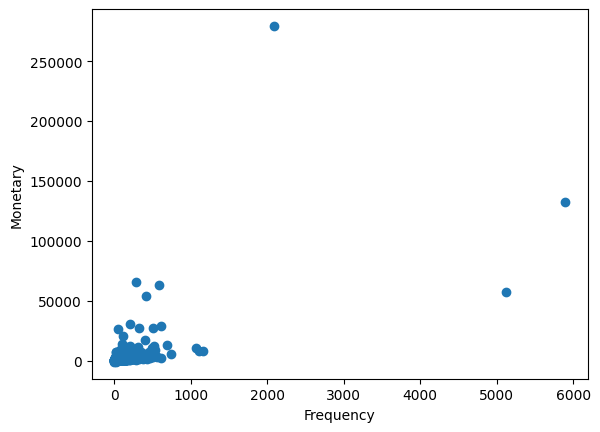

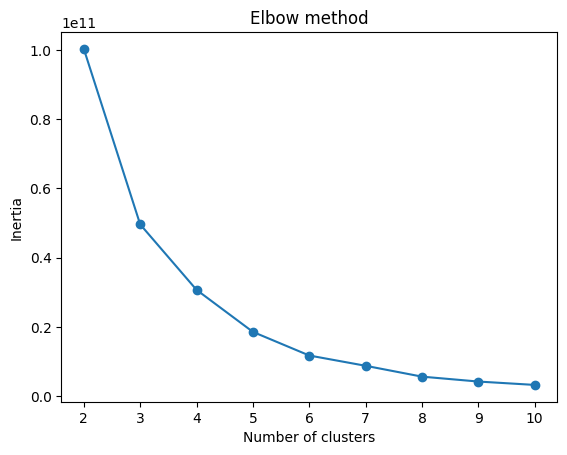


 kmeans.cluster_centers are :
[[0.01077743 0.02247649]
 [0.1036231  0.60620258]
 [0.78536679 0.14737662]]

 kmeans.intertia is :
2.2141122922121848


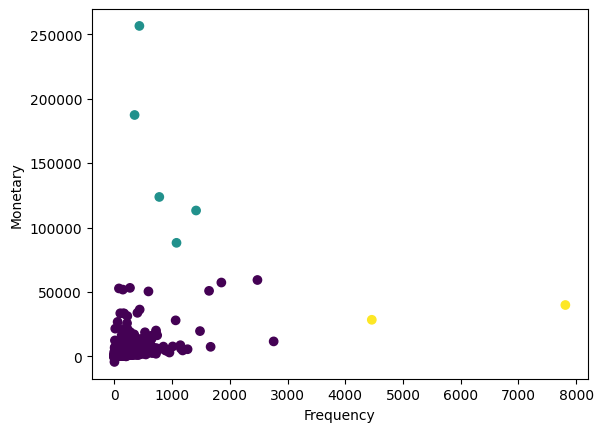


 Result: 9 out of 3497 samples are correctly labeled.

 Accuracy score due to K-Means Model: 0.00

 The Silhouette score for K-Means is : 
0.9695741493881367
Result: 3569 out of 4372 samples are correctly labeled.

 Accuracy score due to Gaussian Mixture Model: 0.82


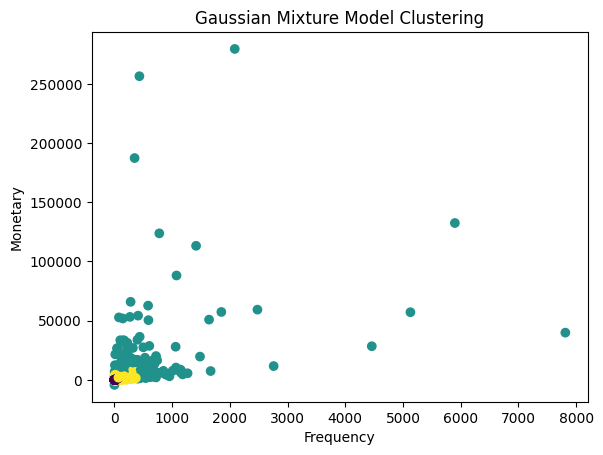

DBSCAN algorithm did not generate enough clusters.


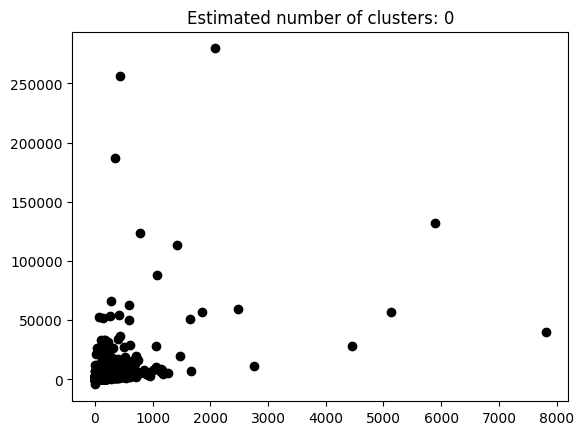

Agglomerative Score is :
0.950218922464673
Clusters of Birch [0 1 2]
Score of Birch =  0.950218922464673


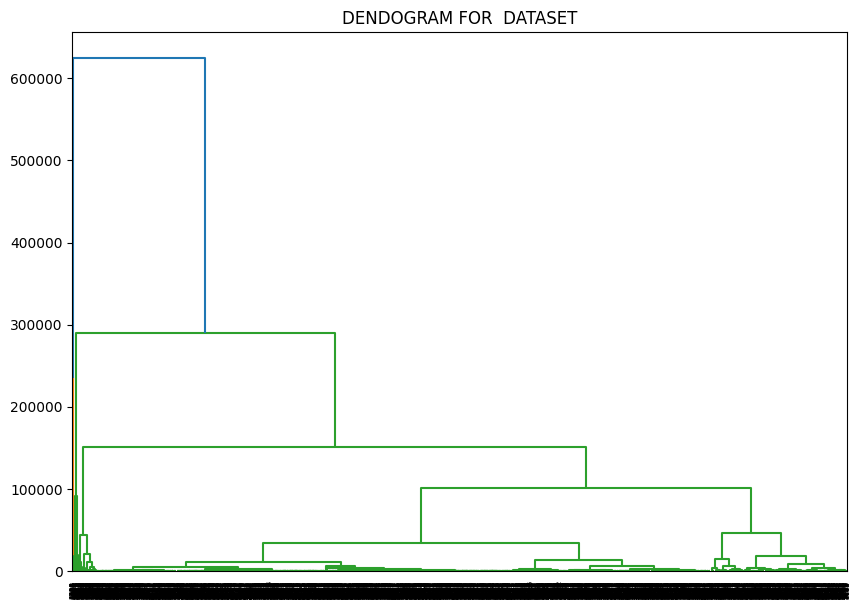

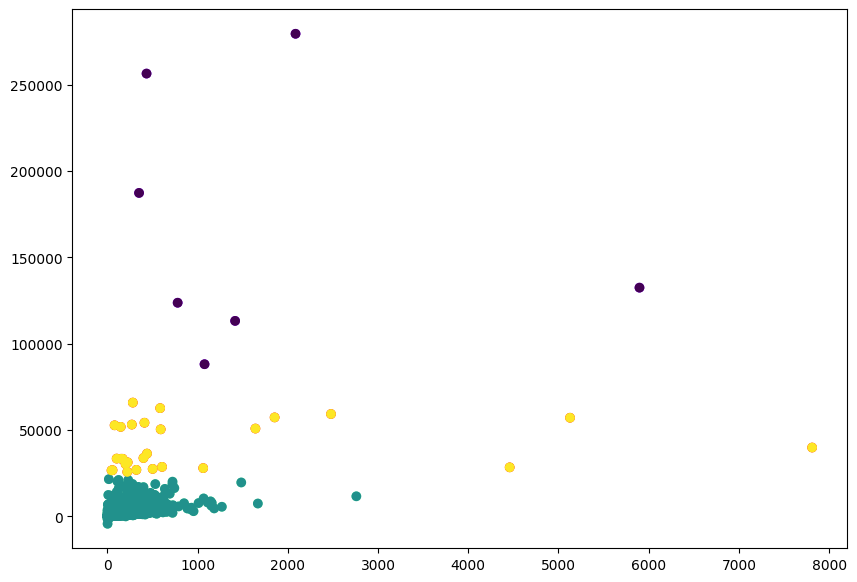

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Read the excel file
with open('online retail.csv', 'r', encoding='latin1', errors='replace') as file:
    data = pd.read_csv(file)

# Data Cleaning

# Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

# Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

# Drop Duplicate Records
data.drop_duplicates(inplace=True)

# Displaying the Cleaned top five records of Dataframe
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print(data.head(5))

# RFM Analysis

# Calculating Recency
data_recency = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = pd.to_datetime(data_recency['LastInvoiceDate'].max(), dayfirst=True)  # Specify dayfirst=True
data_recency['LastInvoiceDate'] = pd.to_datetime(data_recency['LastInvoiceDate'], dayfirst=True)  # Specify dayfirst=True
data_recency['Recency'] = (recent_date - data_recency['LastInvoiceDate']).dt.days
print(data_recency.head(5))

# Calculating Frequency
frequency_data = data.drop_duplicates().groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
print(frequency_data.head(5))

# Calculating Monetary Value
data['Total'] = data['UnitPrice'] * data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
print(monetary_data.head(5))

# Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns='LastInvoiceDate')
print(rfm_data.head(5))

# Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F_rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M_rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
print(rfm_data.head(5))

# Calculating RFM score
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
print(rfm_data[['CustomerID', 'RFM_Score']].head(5))

# Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] > 4.5, "Top Customers",
                                        (np.where(rfm_data['RFM_Score'] > 4,
                                                   "High value Customer",
                                                   (np.where(rfm_data['RFM_Score'] > 3,
                                                             "Medium Value Customer",
                                                             np.where(rfm_data['RFM_Score'] > 1.6,
                                                                      'Low Value Customers',
                                                                      'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
print(rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20))

# Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable
X = rfm_data[['Frequency', 'Monetary']]

# Split the data Train and Test
X_train, X_test = train_test_split(X, random_state=0, train_size=0.80)

# Plot of Train Data
plt.scatter(X_train['Frequency'], X_train['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Plot of Test Data
plt.scatter(X_test['Frequency'], X_test['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Elbow method to visualize the intertia
inertias = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_data[['Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_scaled)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train['Frequency'], X_train['Monetary'], c=kmeans.labels_)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Checking quality of classification by the K-Means model
labels = kmeans.labels_
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Evaluating performance of the clustering algorithm
# using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(metrics.silhouette_score(X_train_scaled, kmeans.labels_, metric='euclidean'))

# Gaussian Mixture Model
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=3)
gmm.fit(scaled_df)

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, len(labels)))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(len(labels))))

# Visualizing the clustering
plt.scatter(X['Frequency'], X['Monetary'], c=labels, cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Gaussian Mixture Model Clustering')
plt.show()

# DBSCAN Clustering Model (Distribution Based)

# Computing DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Check if there is more than one cluster
if n_clusters_ <= 1:
    print("DBSCAN algorithm did not generate enough clusters.")
else:
    # Proceed with silhouette score calculation
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


# Visualizing the clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    if not xy.empty:  # Check if xy DataFrame is not empty
        plt.plot(xy['Frequency'], xy['Monetary'], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Hierarchical Clustering
# Dendrogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method="ward"))

# Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")
cluster.fit_predict(X)
# Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Frequency'], X['Monetary'], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score
print('Agglomerative Score is :')
print(metrics.silhouette_score(X, cluster.labels_, metric='euclidean'))

# BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = np.unique(yhat_br)
print("Clusters of Birch", clusters_br)
labels_br = model_br.labels_
plt.scatter(X['Frequency'], X['Monetary'], c=yhat_br)
score_br = metrics.silhouette_score(X, labels_br)
print("Score of Birch = ", score_br)